In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
cd /home/pimienta/Documents/repos/coding/vocalpy/scipy-proceedings-2023-vak

/home/pimienta/Documents/repos/coding/vocalpy/scipy-proceedings-2023-vak


In [3]:
def munge_df(df):  
    df['avg_err'] = (1.0 - df['avg_val_acc']) * 100
    df['avg_err_tfm'] = (1.0 - df['avg_val_acc_tfm']) * 100
    df['avg_segment_error_rate'] = df['avg_val_segment_error_rate'] * 100
    df['avg_segment_error_rate_tfm'] = df['avg_val_segment_error_rate_tfm'] * 100

    df_out = []

    for value_vars, value_name in zip(
        (
            ['avg_segment_error_rate', 'avg_segment_error_rate_tfm'],
            ['avg_err', 'avg_err_tfm'],
        ),
        (
            'Syllable Error Rate', 'Frame Error',
        )
        
    ):
        melted = pd.melt(df, id_vars=['train_set_dur', 'replicate_num', 'model_name'],
                         value_vars=value_vars,
                         var_name='postprocess',
                         value_name=value_name,
                        )
        post_process_map = dict(zip(value_vars, (False, True)))
        melted['postprocess'] = melted['postprocess'].map(post_process_map)
        df_out.append(melted)

    df_out = pd.merge(*df_out)
    return df_out

In [4]:
RESULTS_ROOT = pathlib.Path('./results/Bengalese_Finches/learncurve/')

In [5]:
NET_NAMES_RESULTS_DIR_MAP = {
    'TweetyNet': 'results/BFSongRepo/all-birds/TweetyNet/results_230628_144709',
    'ED-TCN': 'results/BFSongRepo/all-birds/ED_TCN/results_230628_144655',
    #'TweetyNoLSTMNet': 'results/BFSongRepo/all-birds/TweetyNoLSTMNet/results_230705_120958'
}

In [6]:
data = []
for net_name, results_dir in NET_NAMES_RESULTS_DIR_MAP.items():
    results_dir = pathlib.Path(results_dir)
    csv_path = results_dir / 'learning_curve.csv'
    df = pd.read_csv(csv_path)
    df = df.rename(columns={'train_dur': 'train_set_dur'})
    df = munge_df(df)
    data.append(df)

data = pd.concat(data)

In [7]:
data_plot = data.copy()
data_plot['model_name'] = data_plot['model_name'].map(
    {'TweetyNet': 'TweetyNet', 'ED_TCN': 'ED-TCN'}
)
data_plot['postprocess'] = data_plot['postprocess'].map({True: 'Yes', False: 'No'})
data_plot = data_plot.rename(columns={'postprocess': 'Post-processing'})

In [8]:
sns.set()
sns.set_context('talk')

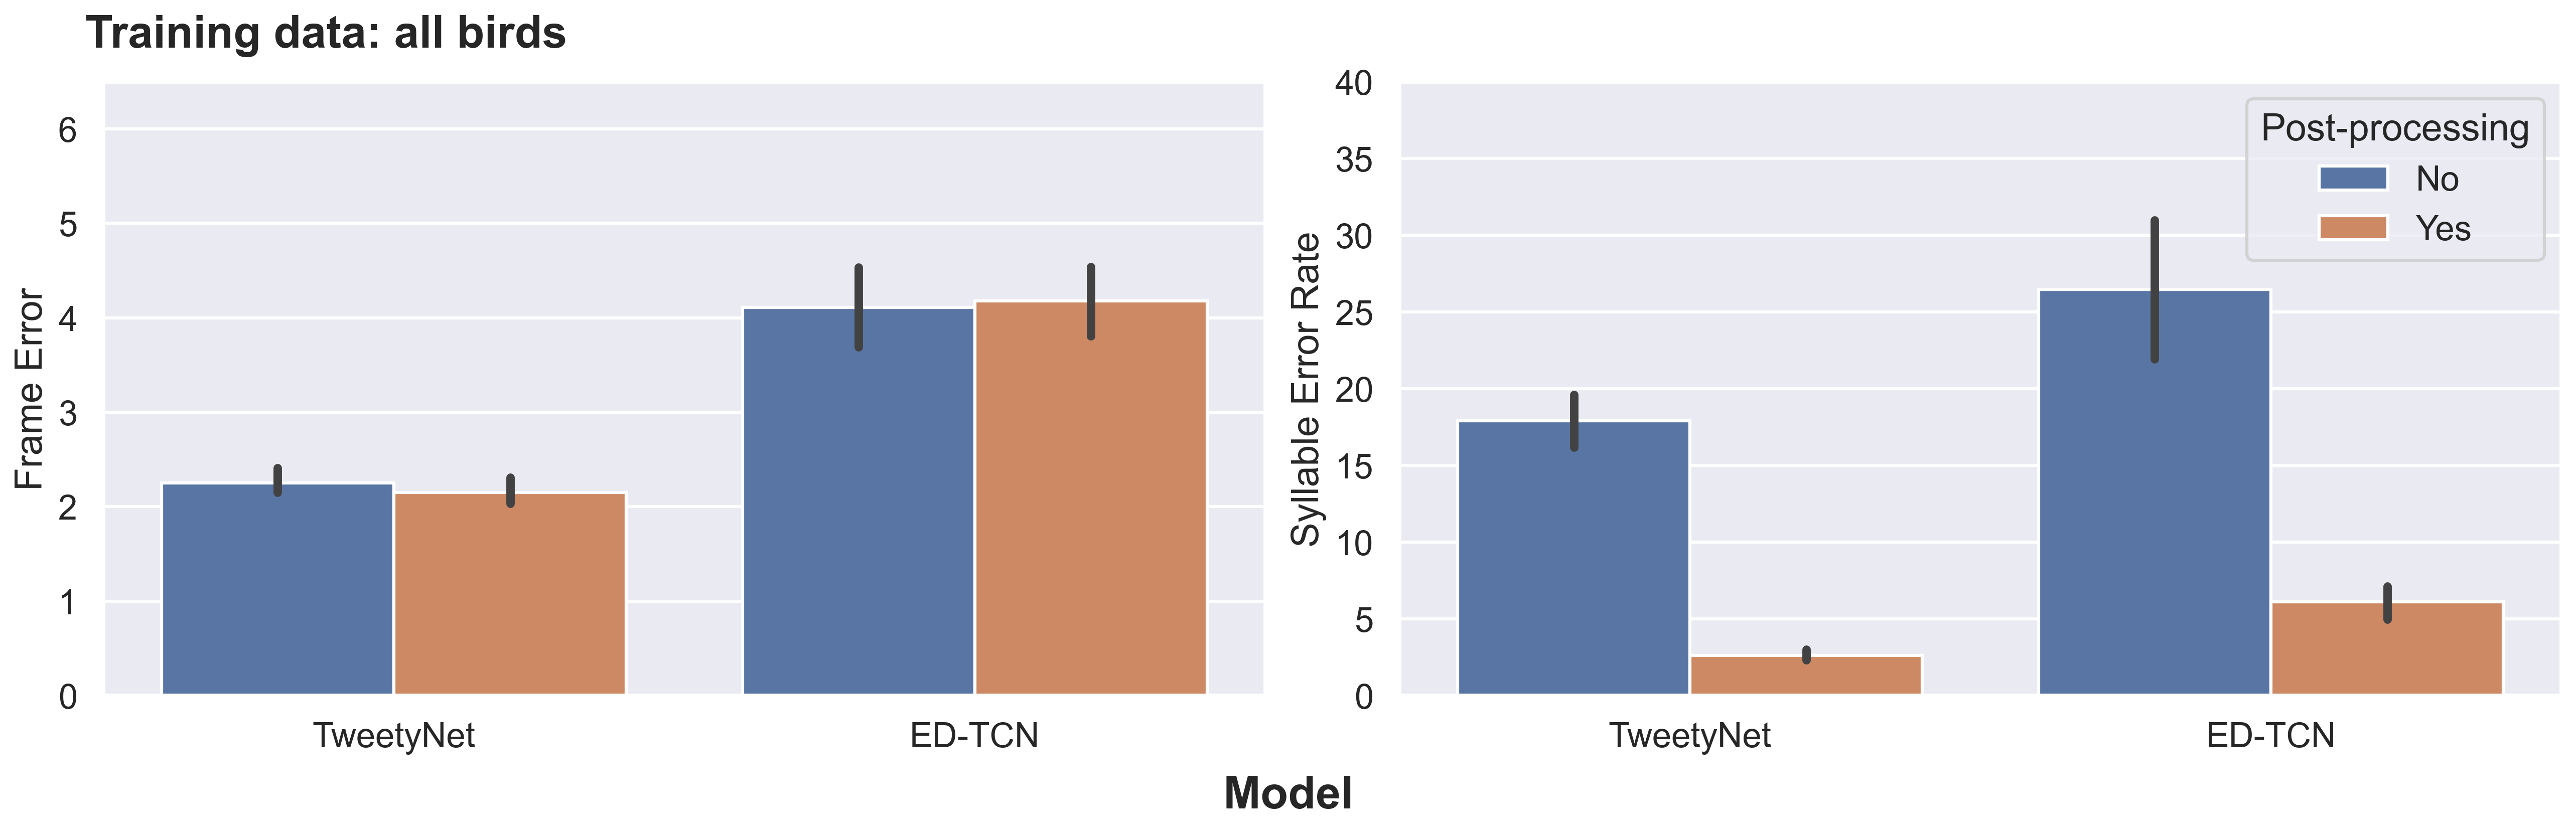

In [9]:
# fig, ax_arr = plt.subplots(2, 2, figsize=(15, 10), dpi=300)
fig = plt.figure(layout='constrained', figsize=(17, 5), dpi=300)
ax_arr = fig.subplots(1, 2)

for subfig_ind, (data_df, subfig_suptitle) in enumerate(
    zip(
        (data_plot,),
        ('Training data: all birds',)
    )
):
    data_plot_ = data_df[data_df.train_set_dur == 600]
    
    for ax_ind, (err_name, ylim) in enumerate(
        zip(
            ('Frame Error', 'Syllable Error Rate'),
            ([0., 6.5], [0., 40.])
        )
    ):
        ax = ax_arr[ax_ind]
        g = sns.barplot(
            data=data_plot_,
            y=err_name,
            x='model_name',
            hue='Post-processing',
            ax=ax,
        )
        ax.set_ylim(ylim)
        ax.set_xlabel('')

        if ax_ind == 0:
            ax.legend().remove()

    fig.suptitle(subfig_suptitle, ha='left', x=0.03, weight='bold')

fig.supxlabel('Model', y=-0.075, weight='bold')
plt.savefig('./doc/figs/TweetyNet-v-EDTCN.png', bbox_inches='tight')
plt.savefig('../scipy_proceedings/papers/david_nicholson/TweetyNet-v-EDTCN.png', bbox_inches='tight')